# Dog Classifier

In this notebook I'll be:
1. Downloading a dataset of labled dog images and syncing them to my sagemaker s3 bucket
2. Performing Hyperparameter Tunning for a pretrained ResNet 18 model
3. Training the model based off of the best found hyperparameters with a debugger and profiler attached
4. Analyze profiler results, adjust hyper parameters further and train model.
5. Deploy the model to an endpoint and make a prediction 

In [2]:
# Install any packages 
!pip install smdebug
!pip install protobuf==3.20.0
!pip install --upgrade bokeh==2.4.3

  Obtaining dependency information for smdebug from https://files.pythonhosted.org/packages/84/6a/d1d35ecbddfadbe1040fa69aaca23665f3ad2c16c519571855589721dfec/smdebug-1.0.34-py2.py3-none-any.whl.metadata
  Using cached smdebug-1.0.34-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp310-cp310-linux_x86_64.whl
Using cached smdebug-1.0.34-py2.py3-none-any.whl (280 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.24.4
    Uninstalling protobuf-4.24.4:
      Successfully uninstalled protobuf-4.24.4

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
  Using cached protobuf-3.20.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation

In [2]:
# Import packages 
import sagemaker
from sagemaker import get_execution_role
import boto3
import os
import subprocess
# import torch


from sagemaker.pytorch import PyTorch
from sagemaker.pytorch import PyTorchModel
from sagemaker import get_execution_role
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

from sagemaker.debugger import (
Rule, ProfilerRule, rule_configs, DebuggerHookConfig, ProfilerConfig, FrameworkProfile
)

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
import IPython
from sagemaker.predictor import Predictor
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
import base64
import numpy as np
from PIL import Image
import io

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
[2023-11-11 21:42:46.897 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:84 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [3]:
# Setup Sagemaker Session 
sagemaker_session = sagemaker.Session(default_bucket='dog-classifier-project')
bucket = sagemaker_session.default_bucket()
execution_role = sagemaker.session.get_execution_role()
region = sagemaker_session.boto_region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


## Dataset
Here I'm downloading a Udacity dataset that is already split up into a test, train and valid directories. Within each of these directories are 133 classes of dog breads (these are reprasented by directectories), within each directory are several jpg images of that particular breed of dog.

In [4]:
#define data location constants
local_data_dir = 'data'  
s3_data_path = f's3://{bucket}/data'
s3_model_path = f's3://{bucket}/model'

In [5]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
subprocess.run(f"unzip dogImages.zip -d {local_data_dir}", shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
os.remove('dogImages.zip')

subprocess.run(f"aws s3 sync ./{local_data_dir} {s3_data_path}", shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

--2023-10-25 19:02:16--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.194.128, 52.219.112.240, 52.219.193.160, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  33.4MB/s    in 28s     

2023-10-25 19:02:46 (37.9 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]



CompletedProcess(args='aws s3 sync ./data s3://dog-classifier-project/data', returncode=0)

## Hyperparameter Tuning
In this section I am setting up the hyper parameter tunning job. I have decided to tune based on learning rate, batch size and the number of epochs the training job should run through (and defining the ranges that the job should search by). The job optomizes primarily upon the average test loss. The training functions along with the logs that the tunning job will optomize upon are produced by the hpo.py script file.

In [6]:
#Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "learningRate": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
    "epochs": IntegerParameter(2, 4)
}

In [9]:
#Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    role=execution_role,
    instance_count=1,
    instance_type="ml.m5.large",
    framework_version="1.8",
    py_version="py36",
)

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "average test loss: ([0-9\\.]+)"}]

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2, 
    objective_type=objective_type,
)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [5]:
data_channels = {
    'train': f'{s3_data_path}/dogImages/train',  # Replace with your S3 path for training data
    'validation': f'{s3_data_path}/dogImages/valid', # Replace with your S3 path for validation data
    'test': f'{s3_data_path}/dogImages/test' 
}

In [11]:
#Fit your HP Tuner

tuner.fit(wait=True, inputs=data_channels, include_cls_metadata=False) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [12]:
# Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-10-25 19:47:19 Starting - Preparing the instances for training
2023-10-25 19:47:19 Downloading - Downloading input data
2023-10-25 19:47:19 Training - Training image download completed. Training in progress.
2023-10-25 19:47:19 Uploading - Uploading generated training model
2023-10-25 19:47:19 Completed - Resource reused by training job: pytorch-training-231025-1911-003-f340996a


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"512"',
 'epochs': '3',
 'learningRate': '0.0020833456548432798',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-10-25-19-11-54-085"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-834277291084/pytorch-training-2023-10-25-19-11-54-085/source/sourcedir.tar.gz"'}

In [6]:
#load best results on kernal restart
tuning_job_name = "pytorch-training-231025-1911"
tuning_job_description = sagemaker_session.sagemaker_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)

print("Tuning job name:", tuning_job_description['HyperParameterTuningJobName'])
print("Tuning job status:", tuning_job_description['HyperParameterTuningJobStatus'])
print("Best training job name:", tuning_job_description['BestTrainingJob']['TrainingJobName'])

best_hyperparameters = tuning_job_description['BestTrainingJob']['TunedHyperParameters']
best_hyperparameters = {
    'batch-size': int(best_hyperparameters['batch-size'].strip('"')),
    'epochs': int(best_hyperparameters['epochs']),
    'learningRate': float(best_hyperparameters['learningRate'])
}
print("Best hyperparameters:", best_hyperparameters)


Tuning job name: pytorch-training-231025-1911
Tuning job status: Completed
Best training job name: pytorch-training-231025-1911-002-ad350472
Best hyperparameters: {'batch-size': 512, 'epochs': 3, 'learningRate': 0.0020833456548432798}


## Model Profiling and Debugging
In this section I will use the best hyper parameters determined by my tunning job to train the ResNet Model while also applying a profiler and debugger to see if I can glean any further optimizations that can be acheived.

In [14]:
#Set up debugging and profiling rules and hooks
#Debug Configs
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)



Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [17]:
# Create and fit an estimator
debug_hyperparameters = best_hyperparameters.copy()
debug_hyperparameters['debug'] = True

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    entry_point="debug.py",
    framework_version="1.8",
    py_version="py36",
    output_path=s3_model_path,
    hyperparameters=debug_hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

estimator.fit(wait=True, inputs=data_channels)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-10-25-21-39-08-560


2023-10-25 21:39:08 Starting - Starting the training job...
2023-10-25 21:39:37 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2023-10-25 21:40:59 Downloading - Downloading input data......
2023-10-25 21:41:59 Training - Downloading the training image...........................
2023-10-25 21:46:40 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-10-25 21:46:43,836 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-10-25 21:46:43,866 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-10-25 21:46:43,868 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-10-25 21:46:44,145 sagemaker-training

In [18]:
# TODO: Plot a debugging output.
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2023-10-25-21-39-08-560
Region: us-east-1


In [19]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())
print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

[2023-10-25 21:55:21.331 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:89 INFO s3_trial.py:42] Loading trial debug-output at path s3://dog-classifier-project/model/pytorch-training-2023-10-25-21-39-08-560/debug-output
[2023-10-25 21:55:21.713 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:89 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-10-25 21:55:22.736 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:89 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.1.relu_input_0', 'layer3.1.relu_input_1', 'layer4.0.relu_input_0', 'layer4.0.relu_input_1', 'layer4.1.relu_input_0', 'l

In [20]:
tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive


ProfilerConfig:{'S3OutputPath': 's3://dog-classifier-project/model', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://dog-classifier-project/model/pytorch-training-2023-10-25-21-39-08-560/profiler-output


Profiler data from system is available
[2023-10-25 21:55:28.504 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:89 INFO metrics_reader_base.py:134] Getting 15 

You will find the profiler report in s3://dog-classifier-project/modelpytorch-training-2023-10-25-21-39-08-560/rule-output


In [21]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Report Analysis 

After looking over the report I think once change I can make is to increase the batch size again and retrain the model one last time. 

In [68]:
print(best_hyperparameters)

{'batch-size': 1024, 'epochs': 3, 'learningRate': 0.0020833456548432798, 'sagemaker_submit_directory': 's3://dog-classifier-project/pytorch-training-2023-10-27-18-24-22-975/source/sourcedir.tar.gz', 'sagemaker_program': 'train_model.py', 'sagemaker_container_log_level': 20, 'sagemaker_job_name': 'pytorch-training-2023-10-27-18-24-22-975', 'sagemaker_region': 'us-east-1'}


In [7]:
best_hyperparameters['batch-size'] = 1024
print(best_hyperparameters)

{'batch-size': 1024, 'epochs': 3, 'learningRate': 0.0020833456548432798}


In [10]:
estimator = PyTorch(
    role=execution_role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    entry_point="train.py",
    framework_version="1.6",
    py_version="py36",
    hyperparameters=best_hyperparameters,
    output_path=s3_model_path,
)

estimator.fit(wait=True, inputs=data_channels)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-10-27-22-17-43-065


Using provided s3_resource
2023-10-27 22:17:43 Starting - Starting the training job...
2023-10-27 22:18:10 Starting - Preparing the instances for training.........
2023-10-27 22:19:29 Downloading - Downloading input data......
2023-10-27 22:20:44 Training - Downloading the training image.........
2023-10-27 22:21:45 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-10-27 22:22:05,429 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-10-27 22:22:05,461 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-10-27 22:22:05,463 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-10-27 22:22:05,747 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
      

## Model Deploying

In [11]:
model_location = estimator.model_data
print(f'model_location: {model_location}')

model_location: s3://dog-classifier-project/model/pytorch-training-2023-10-27-22-17-43-065/output/model.tar.gz


In [5]:
#create predictor
class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = sagemaker.serializers.IdentitySerializer("image/jpeg"),
            deserializer = sagemaker.deserializers.JSONDeserializer()
        )

In [6]:
#load in trained estimator

model_data = "s3://dog-classifier-project/model/pytorch-training-2023-10-27-22-17-43-065/output/model.tar.gz"

model = PyTorchModel(
    model_data=model_data,
    role=execution_role,
    framework_version="1.6",
    py_version="py36",
    entry_point="inference.py",
    predictor_cls = ImgPredictor
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [7]:
predictor=model.deploy(
    initial_instance_count=1, 
    instance_type='ml.m5.large'
) 

endpoint = predictor.endpoint_name
print(endpoint)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
-----!pytorch-inference-2023-11-11-21-43-35-301


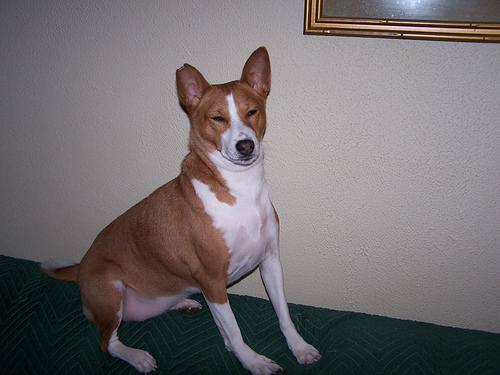

Response: [[-2.622053861618042, -2.9341251850128174, -2.7674052715301514, -0.36216872930526733, -2.082024574279785, -2.32547926902771, 0.8826775550842285, 0.5573564171791077, -2.8919317722320557, -2.270203113555908, -0.3622225224971771, -2.6999337673187256, -3.019976854324341, 1.911210298538208, -0.4759663939476013, -0.5236372351646423, -4.617607593536377, -3.165351629257202, -2.1187400817871094, -0.7937986850738525, -3.2381622791290283, -3.1481223106384277, -3.6793248653411865, -2.3200628757476807, -2.967003107070923, -3.634042263031006, -1.6929047107696533, -3.6063072681427, -2.7454094886779785, -2.8130109310150146, -2.111844778060913, 0.4692836403846741, -3.105921983718872, -0.9666253924369812, -3.670046329498291, -3.933622121810913, -2.7009270191192627, -3.512342929840088, 1.3157213926315308, -1.728029489517212, -1.2828731536865234, -2.8941845893859863, -0.26369962096214294, -2.8719866275787354, 0.7674469947814941, -2.6304991245269775, -2.045952320098877, 1.756546974182129, -0.2962

In [12]:

with open("./data/dogImages/test/014.Basenji/Basenji_00955.jpg", "rb") as f:
    image = f.read()
    display(Image.open(io.BytesIO(image)))
    response = predictor.predict(image, initial_args={"ContentType": "image/jpeg"})
    print(f"Response: {response}")
    dog_breed = np.argmax(response, 1) + 1 #get the max value of the predicted probabilities 
    print(f"Response/Inference for the above image is : {dog_breed}")

In [13]:
# the above image is of a basenji has the class number of 14 which is what the model predicted. 

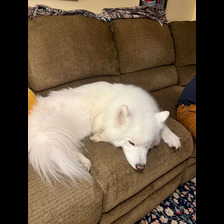

Response: [[-1.5006978511810303, -2.1696267127990723, -2.3832919597625732, 0.5314987301826477, -0.2952699661254883, 0.9027979969978333, -1.705180048942566, -1.2752203941345215, -2.899099588394165, -1.238516092300415, -1.3409637212753296, -2.4904327392578125, -4.335453510284424, -1.692713737487793, -2.1791422367095947, -2.969911813735962, -2.8273637294769287, -3.041901111602783, 0.48049628734588623, -3.1392769813537598, -1.6782100200653076, -2.6589057445526123, -3.5742177963256836, 0.1768590658903122, -3.838792085647583, -2.625990390777588, -2.0571539402008057, -3.470722198486328, -2.134507179260254, -2.487032175064087, -1.3599700927734375, -2.579188108444214, -2.375839948654175, -2.871751308441162, -3.66984486579895, -2.8565473556518555, -2.639674425125122, -2.4431612491607666, 0.4632660150527954, -0.8142460584640503, -2.8934643268585205, -2.294294834136963, 0.07341056317090988, -4.0857834815979, -1.602561593055725, -2.424424409866333, -2.1915929317474365, -1.3994618654251099, -0.23164

In [13]:
#going to try to use the model on random image from home
with open("./data/dogImages/sample_dog.jpg", "rb") as f:
    image = f.read()
    display(Image.open(io.BytesIO(image)))
    response = predictor.predict(image, initial_args={"ContentType": "image/jpeg"})
    print(f"Response: {response}")
    sorted_indices = np.argsort(response, axis=1)
    top_5_breeds = sorted_indices[:, -5:] + 1
    print(f"Response/Inference for the above image is : {top_5_breeds}")

In [16]:
## Model predicts:

# 1. Class 79: Great Pyrenees
# 2. Class 6: American Eskimo
# 3. Class 95: Kuvasz
# 4. Class 4: Akita
# 5. Class 19: Bedlington Terrier

# Owner says dog is American Eskimo

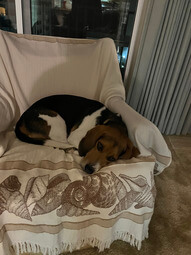

Response: [[-1.4270353317260742, -2.7062673568725586, -2.2813234329223633, -0.850902259349823, -1.4106045961380005, -1.8013677597045898, -1.2668298482894897, -1.8757765293121338, -1.8501930236816406, -0.9433218240737915, -0.13294367492198944, -2.0283701419830322, -3.2761168479919434, -1.4550399780273438, -2.3453402519226074, -2.7390170097351074, -3.442957639694214, -2.313424587249756, -1.9027738571166992, -2.4618170261383057, -1.6277047395706177, -2.941602945327759, -1.7947885990142822, -2.6341333389282227, -3.3485870361328125, -1.7074315547943115, -1.421226143836975, -1.7994493246078491, -1.923583745956421, -2.041137218475342, -1.8278721570968628, -1.3944969177246094, -1.728827953338623, -1.9187257289886475, -2.7160911560058594, -3.025704860687256, -2.1623141765594482, -2.3301234245300293, -1.3717557191848755, -0.8466425538063049, -1.6522002220153809, -2.779628038406372, -1.6029635667800903, -2.1906633377075195, -0.7375212907791138, -2.0644588470458984, -3.1113827228546143, -2.0563869

In [8]:
with open("./data/dogImages/sample_dog_2.jpg", "rb") as f:
    image = f.read()
    display(Image.open(io.BytesIO(image)))
    response = predictor.predict(image, initial_args={"ContentType": "image/jpeg"})
    print(f"Response: {response}")
    sorted_indices = np.argsort(response, axis=1)
    top_5_breeds = sorted_indices[:, -5:] + 1
    print(f"Response/Inference for the above image is : {top_5_breeds}")

In [ ]:
## Model predicts:

# 1. Class 79: Great Pyrenees
# 2. Class 6: American Eskimo
# 3. Class 95: Kuvasz
# 4. Class 4: Akita
# 5. Class 19: Bedlington Terrier

# Owner says dog is American Eskimo

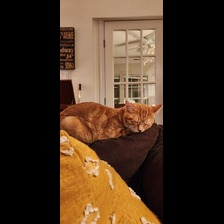

Response: [[-1.835818886756897, -2.223686695098877, -2.1420257091522217, -0.43986332416534424, -1.8820993900299072, -2.5243842601776123, -0.19599364697933197, -1.2199313640594482, -2.0765953063964844, -2.0152230262756348, -1.0441298484802246, -2.2212212085723877, -3.258721113204956, -1.0949345827102661, -1.1906490325927734, -1.8503670692443848, -3.8112635612487793, -4.158026218414307, -1.2358959913253784, -2.7335076332092285, -2.269829034805298, -2.5254476070404053, -2.5007081031799316, -2.0321218967437744, -3.0906600952148438, -1.7517985105514526, -0.4927070438861847, -2.6255948543548584, -2.128052234649658, -0.9620850086212158, -1.6280819177627563, -2.346885919570923, -0.6535401344299316, -2.3557240962982178, -3.5940492153167725, -3.341768741607666, -2.558743476867676, -2.3309412002563477, -1.3795888423919678, -1.534417748451233, -1.2269753217697144, -2.802180051803589, -1.0066784620285034, -3.247727870941162, -0.7629075646400452, -2.430760622024536, -1.4948580265045166, -2.210909366

In [9]:
with open("./data/dogImages/cat_image.jpg", "rb") as f:
    image = f.read()
    display(Image.open(io.BytesIO(image)))
    response = predictor.predict(image, initial_args={"ContentType": "image/jpeg"})
    print(f"Response: {response}")
    sorted_indices = np.argsort(response, axis=1)
    top_5_breeds = sorted_indices[:, -5:] + 1
    print(f"Response/Inference for the above image is : {top_5_breeds}")

In [ ]:
## Model predicts:

# 1. Class 90: Italian Greyhound
# 2. Class 6: Americn Foxhound
# 3. Class 67: Finnish Spitz
# 4. Class 60: Dogue De Bordeaux
# 5. Class 121: Plott

# Owner says dog is a Cat

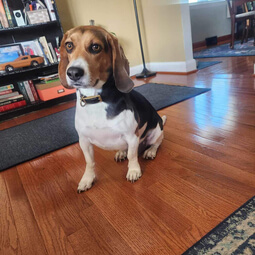

Response: [[-3.90480637550354, -3.0069313049316406, -2.730506420135498, -1.9568901062011719, -2.6099376678466797, -3.777801036834717, 1.8861777782440186, -0.2005755603313446, -2.977294683456421, -1.9633784294128418, -2.244258403778076, -2.8222992420196533, -4.1456217765808105, -0.7344447374343872, 1.2706745862960815, 1.0904717445373535, -2.705676794052124, -4.325931549072266, -1.59653902053833, -3.192014694213867, -3.57487154006958, -4.514767169952393, -1.6331117153167725, -2.5885331630706787, -2.6260032653808594, -3.0367133617401123, -0.6478745937347412, -0.9141169786453247, -2.287964344024658, -3.7021138668060303, -2.511502504348755, -1.0976336002349854, -3.041217088699341, -0.7581498622894287, -2.3913216590881348, -3.6791324615478516, -0.5217320919036865, -4.897209644317627, -1.0130558013916016, -0.27989915013313293, -2.159493923187256, -4.991073131561279, -1.9539140462875366, -2.5873312950134277, -0.3507220447063446, -1.677044153213501, -2.4011173248291016, -2.0371780395507812, -1.

In [8]:
with open("./data/dogImages/bagel.jpg", "rb") as f:
    image = f.read()
    display(Image.open(io.BytesIO(image)))
    response = predictor.predict(image, initial_args={"ContentType": "image/jpeg"})
    print(f"Response: {response}")
    sorted_indices = np.argsort(response, axis=1)
    top_5_breeds = sorted_indices[:, -5:] + 1
    print(f"Response/Inference for the above image is : {top_5_breeds}")

In [ ]:
## Model predicts:

# 1. Class 56: Dachshund
# 2. Class 80: Greater Swiss Mountain Dog
# 3. Class 16: Beagle
# 4. Class 15: Basset Hound
# 5. Class 7: Amercian Fox Hound

# Owner says dog is a Beagle

In [10]:
# Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()